# Employee Satisfaction Analysis at SF Motors

In this project, the HR department of Salifort Motors seeks to enhance employee satisfaction and retention. My task involves analyzing this data and constructing a predictive model to ascertain the likelihood of an employee leaving the company. By identifying employees prone to quitting, the project aims to uncover the factors influencing their decisions. This initiative is crucial as improved employee retention can save time and resources spent on recruiting and onboarding new staff, benefiting the company overall.

In [2]:
# IMPORT & READ
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data
df = pd.read_csv('HR_capstone_dataset.csv')

target = 'left'

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


# FUNCTIONS

In [4]:
# MUTUAL_INFORMATION

from sklearn.feature_selection import mutual_info_regression
def m_info_r(X, y):
   
    X_encoded = X.select_dtypes(include="object").apply(lambda x: x.factorize()[0])  # Label encoding for categorical
    
    X_combined = pd.concat([X_encoded, X.select_dtypes(exclude="object")], axis=1) # Combined categorical & numerical col
    
    mi_scores = mutual_info_regression(X_combined, y, discrete_features="auto", random_state=0) # Calculate mi scores
    
    # Create a Series with feature names as index and sorted mutual information scores
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_combined.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    
    return mi_scores

from sklearn.feature_selection import mutual_info_classif
def m_info_c(X, y):
    
    X_encoded = X.select_dtypes(include="object").apply(lambda x: x.factorize()[0]) # Label encoding for categoricals
    
    X_combined = pd.concat([X_encoded, X.select_dtypes(exclude="object")], axis=1) # Combine categorical & numerical columns
    
    # Calculate mutual information scores using mutual_info_classification
    mi_scores = mutual_info_classif(X_combined, y, discrete_features="auto", random_state=0)
    
    # Create a Series with feature names as index and sorted mutual information scores
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_combined.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    
    return mi_scores
 
def plot_mi_scores(mi_scores, top_n=20):
    plt.figure(dpi=100, figsize=(10, 6))
    sns.barplot(x=mi_scores.head(top_n), y=mi_scores.head(top_n).index, palette='viridis')
    plt.title("Mutual Information Scores")
    plt.show()

In [5]:
# SEABORN_VISUALIZATION

def visualize_numerical_columns(df, num_cols_per_row=3):
    # Select numerical columns
    numerical_cols = df.select_dtypes(include=[np.number]).columns

    # Calculate the number of rows needed for subplots
    num_rows = (len(numerical_cols) - 1) // num_cols_per_row + 1

    # Set plot style and palette
    sns.set_style("dark")
    sns.set_palette("dark")

    # Create subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols_per_row, figsize=(12, 4 * num_rows))
    fig.tight_layout(pad=4.0)

    # Plot histograms for numerical columns
    for ax, col in zip(axes.flatten(), numerical_cols):
        sns.histplot(df[col], ax=ax, edgecolor='white', color='#a2d2ff', bins=20)
        ax.set_title(f'Distribution of {col}')
        ax.set_xlabel('')
        ax.set_ylabel('Count')

    # Remove empty subplots
    if len(numerical_cols) % num_cols_per_row != 0:
        empty_subplots = num_rows * num_cols_per_row - len(numerical_cols)
        for ax in axes.flatten()[-empty_subplots:]:
            ax.remove()

    plt.show()

def seaborn_correlation_matrix(df):
    sns.set_theme(style="white")

    # Compute the correlation matrix
    corr = df.corr(numeric_only=True)

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(6, 4))

    # Generate a custom colormap
    cmap = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False, annot_kws={"fontsize": 8})

    # Show the plot
    plt.show()

def visualize_binary_relationships(df, target_column):
    g = sns.pairplot(data=df, hue=target_column, palette='seismic', height=1.2, diag_kind='kde', diag_kws=dict(fill=True), plot_kws=dict(s=10))
    g.set(xticklabels=[])




In [6]:
# PLOTLY_VISUALIZATION

import plotly.graph_objects as go
import plotly.express as px


def explore_dependent_variable(target):
    # Fit a normal distribution to the target data
    mu, sigma = stats.norm.fit(target)

    # Create a histogram of the target column
    hist_data = go.Histogram(x=target, nbinsx=50, name="Histogram", opacity=0.75, histnorm='probability density', marker=dict(color='blueviolet'))

    # Calculate the normal distribution based on the fitted parameters
    x_norm = np.linspace(target.min(), target.max(), 100)
    y_norm = stats.norm.pdf(x_norm, mu, sigma)

    # Create the normal distribution overlay
    norm_data = go.Scatter(x=x_norm, y=y_norm, mode="lines", name=f"Normal dist. (μ={mu:.2f}, σ={sigma:.2f})", line=dict(color="green"))

    # Combine the histogram and the overlay
    fig = go.Figure(data=[hist_data, norm_data])

    # Set the layout for the plot
    fig.update_layout(
        title="Dependent Variable Distribution",
        xaxis_title="Dependent Variable",
        yaxis_title="Density",
        legend_title_text="Fitted Normal Distribution",
        plot_bgcolor='rgba(32, 32, 32, 1)',
        paper_bgcolor='rgba(32, 32, 32, 1)',
        font=dict(color='white')
    )



   

    # Show the plots
    fig.show()
    


def explore_categorical_relationships(df, group_column, target_column):
    grouped_counts = df[group_column].value_counts()
    grouped_averages = df.groupby(group_column)[target_column].mean()

    formatted_averages = ['$' + f'{value:,.2f}' for value in grouped_averages.values]

    fig1 = go.Figure(data=[go.Bar(
        x=grouped_counts.index,
        y=grouped_counts.values,
        marker_color='rgb(76, 175, 80)',
        text=grouped_counts.values,
        textposition='outside',
        width=0.4,
        marker=dict(line=dict(width=2, color='rgba(0,0,0,1)'), opacity=1)
    )])
    fig1.update_layout(
        title=f'Distribution of {group_column}',
        xaxis_title=group_column,
        yaxis_title='Count',
        plot_bgcolor='rgba(34, 34, 34, 1)',
        paper_bgcolor='rgba(34, 34, 34, 1)',
        font=dict(color='white'),
        height=500  # Adjust the height value as desired
    )

    fig2 = go.Figure(data=[go.Bar(
        x=grouped_averages.index,
        y=grouped_averages.values,
        marker_color='rgb(156, 39, 176)',
        text=formatted_averages,
        textposition='outside',
        width=0.4,
        marker=dict(line=dict(width=2, color='rgba(0,0,0,1)'), opacity=1)
    )])
    fig2.update_layout(
        title=f'Average {target_column} by {group_column}',
        xaxis_title=group_column,
        yaxis_title=target_column,
        plot_bgcolor='rgba(34, 34, 34, 1)',
        paper_bgcolor='rgba(34, 34, 34, 1)',
        font=dict(color='white'),
        height=500  # Adjust the height value as desired
    )

    fig1.show()
    fig2.show()


def explore_numerical_correlation(df, feature_column, target_column):
    # Calculate correlation between feature and target
    feature_target_corr = df[feature_column].corr(df[target_column])
    print(f'Correlation between {feature_column} and {target_column}: {feature_target_corr}')

    # Create a scatter plot to visualize the relationship between feature and target
    fig = px.scatter(df, x=feature_column, y=target_column, title=f'{feature_column} vs {target_column}', color=feature_column, color_continuous_scale=px.colors.sequential.Purp)
    fig.update_layout(plot_bgcolor='rgb(30,30,30)', paper_bgcolor='rgb(30,30,30)', font=dict(color='white'))
    fig.show()



In [7]:
# ENCODE_DATA

import category_encoders as ce

def encode_data(df):
    # Suburb: Target Encoding
    suburb_target_encoding = df.groupby('Column Name')[target].mean()
    df['Column Name'] = df['Column Name'].map(suburb_target_encoding)

    # Hash Encoding
    encoder = ce.HashingEncoder(cols=['Column Name'])
    df_encoded = encoder.fit_transform(df)

    # Frequency Encoding based on Mean Price
    sellerg_frequency_encoding = df.groupby('Column Name')[target].mean()
    df_encoded['Column Name'] = df_encoded['Column Name'].map(sellerg_frequency_encoding)

    # Date Encoding
    '''
    df_encoded['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', dayfirst=True)
    df_encoded['Year'] = df_encoded['Date'].dt.year
    df_encoded['Month'] = df_encoded['Date'].dt.month
    df_encoded['Day'] = df_encoded['Date'].dt.day
    df_encoded.drop('Date', axis=1, inplace=True)
    '''

    # CouncilArea: Frequency Encoding based on Target
    council_area_frequency_encoding = df.groupby('Column Name')[target].mean()
    df_encoded['Column Name'] = df_encoded['Column Name'].map(council_area_frequency_encoding)

    # One-Hot Encoding
    df_encoded = pd.get_dummies(df_encoded, columns=['Column Name'])

    return df_encoded



In [8]:
# EXTRACT_OUTLIERS

def extract_outliers(dataframe):
    outliers_data = []
    for column in dataframe.columns:
        if dataframe[column].dtype != 'object':  # Skip columns with non-numeric data types
            array = dataframe[column]
            # Get quartiles and IQR
            q1, q3 = np.percentile(array, [25, 75])
            iqr = q3 - q1

            # Calculate upper and lower bounds
            upper_bound = q3 + (1.5 * iqr)
            lower_bound = q1 - (1.5 * iqr)

            outliers = array[(array <= lower_bound) | (array >= upper_bound)]
            total_outliers = len(outliers)
            outliers_data.append({'Column': column, 'Total Outliers': total_outliers})

    outliers_df = pd.DataFrame(outliers_data)
    return outliers_df

def plot_outliers(data, plot_type='violin', figsize=(10, 6)):
    # Set up the figure and axes
    fig, ax = plt.subplots(figsize=figsize)

    # Choose plot type
    if plot_type == 'violin':
        sns.violinplot(data=data, ax=ax, inner="quartile", palette="pastel")
    elif plot_type == 'box':
        sns.boxplot(data=data, ax=ax)
    else:
        raise ValueError('Invalid plot type. Choose "violin" or "box".')

    # Set labels and title
    ax.set(xlabel='Columns', ylabel='Values', title='Outliers in Columns')

    # Rotate x-axis labels if needed
    ax.tick_params(axis='x') 

    # Remove the top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add a grid for better readability
    ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='gray')

    # Adjust the aspect ratio of the subplots
    plt.subplots_adjust(wspace=0.5, hspace=0.5)

    # Show the plot
    plt.show()

In [9]:
# REMOVE_OUTLIERS


#(Skewed Distribution)
def remove_outliers_IQR(df, column=None, k=3):
    if column is None:
        numeric_columns = df.select_dtypes(include=np.number).columns
    else:
        numeric_columns = [column]

    Q1 = df[numeric_columns].quantile(0.25)
    Q3 = df[numeric_columns].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR

    outliers = df[(df[numeric_columns] < lower_bound) | (df[numeric_columns] > upper_bound)].any(axis=1)
    df_out = df[~outliers]

    return df_out

    # Example: remove_outliers_IQR(df, column=None, k=1.5)


#(Normal Distribution)
def remove_outliers_z_scores(df, column, z_score_lower=None, z_score_upper=None, z_score_threshold=None):
    if z_score_lower is not None and z_score_upper is not None:
        z_scores = scipy.stats.zscore(df[column])
        outliers = (z_scores < z_score_lower) | (z_scores > z_score_upper)
    elif z_score_threshold is not None:
        z_scores = scipy.stats.zscore(df[column])
        outliers = np.abs(z_scores) > z_score_threshold
    else:
        raise ValueError("Please specify either z_score_lower and z_score_upper or z_score_threshold.")
    
    return df[~outliers]

    # Example: remove_outliers_z_scores(df, 'column', z_score_lower=-1.96, z_score_upper=1.96)



# DATA EXPLORATION


In [10]:
# INFO

# Display the shape of the data
print("Data Shape:")
print(df.shape)

# Check for any duplicate entries in the data.
print('')
print("Duplicate Values:")
print('(',df.duplicated().sum(),')')


# Display the data types of the columns
print("\nData Types:")
print(df.dtypes.value_counts())

# Check for missing values
missing_columns = df.columns[df.isnull().any()]
if missing_columns.size > 0:
    missing_values = df[missing_columns].isnull().sum()
    missing_percentage = (missing_values / len(df)) * 100

    # Combine missing_values and missing_percentage into a single DataFrame
    missing_data = pd.concat([missing_values, missing_percentage], axis=1, keys=['Total', 'Percent'])

    # Sort the missing_data DataFrame by Total column in descending order
    missing_data = missing_data.sort_values(by='Total', ascending=False)

    # Print missing data
    print("\nMissing Data:")
    print(missing_data.to_string())
else:
    print("\nNo Missing Values Found")



Data Shape:
(14999, 10)

Duplicate Values:
( 3008 )

Data Types:
int64      6
float64    2
object     2
dtype: int64

No Missing Values Found


In [11]:
# Remove duplicates

df.drop_duplicates(keep='first', inplace=True)

print('Duplicate Values:',df.duplicated().sum())


Duplicate Values: 0


In [12]:
# Rename columns

def clean_data(df):
    
    column_mapping = {
        'Work_accident': 'work_accident',
        'Department': 'department'
    }
    df.rename(columns=column_mapping, inplace=True)
    return df

clean_data(df)
df.columns


Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

**CATEGORICAL ANALYSIS**

In [13]:
# ENCODING RECOMMENDATIONS

def get_encoding_recommendations(df):
    encoding_recommendations = []

    for column in df.select_dtypes(include='object'):
        unique_values = df[column].nunique()

        if unique_values <= 10:
            encoding = 'One-Hot / Label'
        elif unique_values >= 10:
            encoding = 'Target / Frequency'
        else:
            encoding = 'Date Encoding' if df[column].dtype == 'datetime64[ns]' else 'None'

        encoding_recommendations.append({
            'Feature': column,
            'Unique Values': unique_values,
            'Recommended Encoding': encoding
        })

    return pd.DataFrame(encoding_recommendations)

# Example usage with your DataFrame
df_encoding_recommendations = get_encoding_recommendations(df)
df_encoding_recommendations


,Feature,Unique Values,Recommended Encoding
0,department,10,One-Hot / Label
1,salary,3,One-Hot / Label


In [14]:
# Salary Recommendations

explore_categorical_relationships(df, 'salary', target)



**Employee Retention and Salary Insights**

Our study confirms that higher salaries correlate with lower employee turnover, emphasizing the significance of competitive compensation. Addressing salary discrepancies and tailoring retention plans can foster greater employee loyalty, resulting in reduced turnover costs and enhanced company stability. 

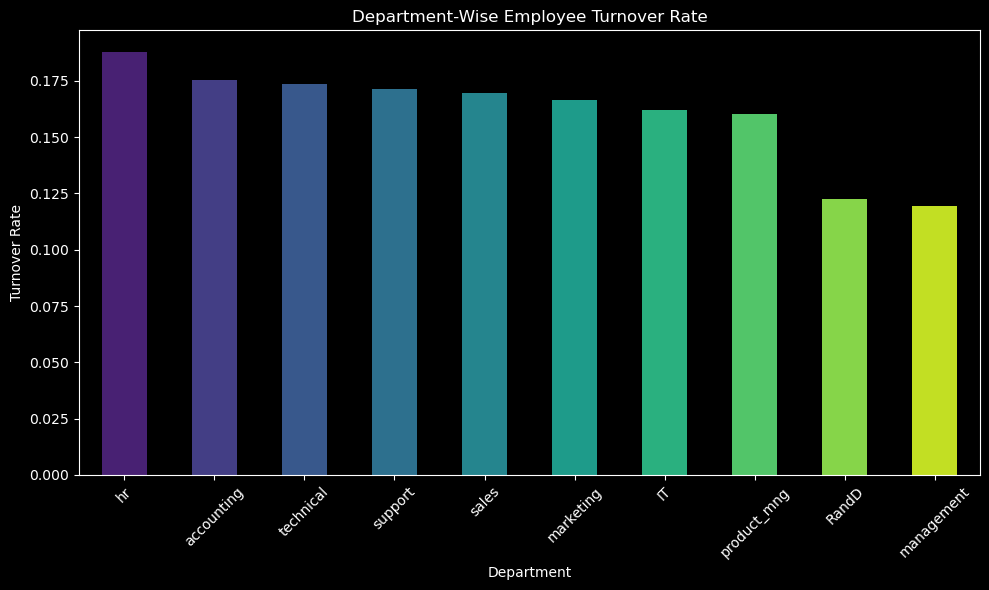

In [15]:
# Calculate the mean turnover rate by department and sort in descending order
department_turnover = df.groupby('department')['left'].mean().sort_values(ascending=False)

# Set a dark background style
plt.style.use('dark_background')

# Define custom colors
colors = sns.color_palette("viridis", len(department_turnover))

# Create a bar plot
plt.figure(figsize=(10, 6))
department_turnover.plot(kind='bar', color=colors)
plt.title('Department-Wise Employee Turnover Rate')
plt.xlabel('Department')
plt.ylabel('Turnover Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



**Retention-Focused Interventions for HR Department:**
The HR department exhibits the highest turnover rate at 18.80%. This suggests that there might be internal challenges affecting employee satisfaction, engagement, or career growth. Implementing targeted interventions, such as enhancing communication channels, providing growth opportunities, and addressing work-life balance, could address underlying issues.

**Learning from Low Turnover Departments:**
Departments like Management, Research & Development (RandD), and Product Management showcase remarkably lower turnover rates, around 11.93% to 12.25%. These departments likely have effective practices in place that foster employee satisfaction, development, and well-being


**Conclusion:**
It's essential to adopt a holistic approach to retention across all departments. This includes regular check-ins, addressing feedback promptly, providing growth opportunities, and promoting a culture of inclusivity and well-being.

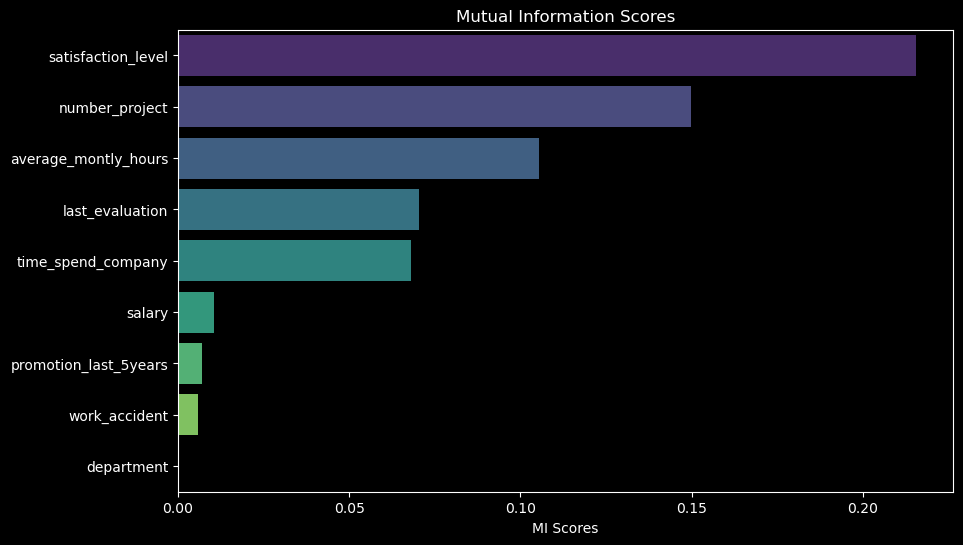

In [16]:
# MUTUAL INFORMATION SCORES

# Create a new DataFrame without null values
df_m = df.copy(deep=True)

# Calculate mutual information scores
X_m = df_m
y_m = X_m.pop(target)

# Calculate mutual information (_r or _c)
m_info_scores = m_info_r(X_m, y_m)

# Plot the mutual information scores
plot_mi_scores(m_info_scores, top_n=20)



**Key Insights from Mutual Information Scores on Employee Turnover:**

1. **Satisfaction Level (0.216)**: Strongly linked to turnover, higher satisfaction indicates potential retention.
2. **Number of Projects (0.150)**: More projects might contribute to turnover due to increased workload.
3. **Average Monthly Hours (0.105)**: Moderate association with turnover; longer hours could impact satisfaction.
4. **Time Spent with Company (0.068)**: Tenure affects retention; longer time might signal loyalty.

These scores help prioritize strategies, emphasizing satisfaction, project distribution, working hours, and tenure for effective employee retention efforts.

**NUMERICAL ANALYSIS**


Highest Correlation Values:
number_project        average_montly_hours    0.331516
last_evaluation       number_project          0.270256
average_montly_hours  last_evaluation         0.264678
time_spend_company    number_project          0.188837
left                  time_spend_company      0.173295
dtype: float64


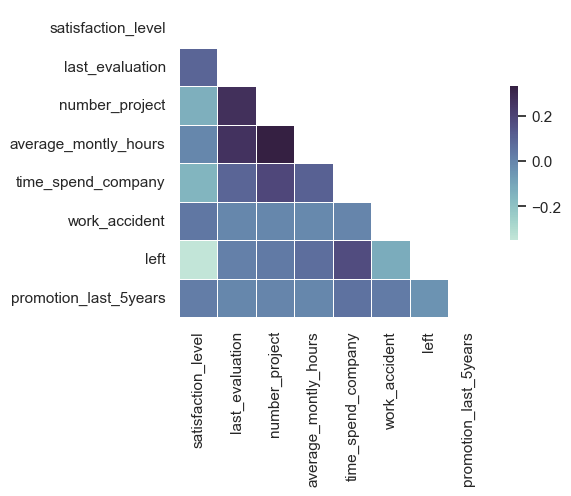

In [17]:
# CORRELATION

correlation_matrix = df.corr(numeric_only=True)

# Get the highest correlation values (excluding self-correlations)
highest_corr = correlation_matrix.unstack().sort_values(ascending=False).drop_duplicates()
highest_corr = highest_corr[(highest_corr != 1.0) & (highest_corr > 0)]

# Display the highest correlation values
print("\nHighest Correlation Values:")
print(highest_corr[:5])



seaborn_correlation_matrix(df)

**Correlations Summary:**

1. **Workload & Hours (0.332)**: More projects align with increased monthly work hours.
2. **Evaluation & Engagement (0.270)**: Active project involvement links to higher evaluation frequency.
3. **Tenure & Projects (0.189)**: Longer tenure corresponds to handling more projects.


In [18]:
# STATS
summary = df.describe().T.sort_values(by='std', ascending=False).head(10)
summary

,count,mean,std,min,25%,50%,75%,max
average_montly_hours,11991.0,200.473522,48.727813,96.00,157.00,200.00,243.00,310.0
time_spend_company,11991.0,3.364857,1.330240,2.00,3.00,3.00,4.00,10.0
number_project,11991.0,3.802852,1.163238,2.00,3.00,4.00,5.00,7.0
left,11991.0,0.166041,0.372133,0.00,0.00,0.00,0.00,1.0
work_accident,11991.0,0.154282,0.361234,0.00,0.00,0.00,0.00,1.0
satisfaction_level,11991.0,0.629658,0.241070,0.09,0.48,0.66,0.82,1.0
last_evaluation,11991.0,0.716683,0.168343,0.36,0.57,0.72,0.86,1.0
promotion_last_5years,11991.0,0.016929,0.129012,0.00,0.00,0.00,0.00,1.0


**TARGET ANALYSIS**

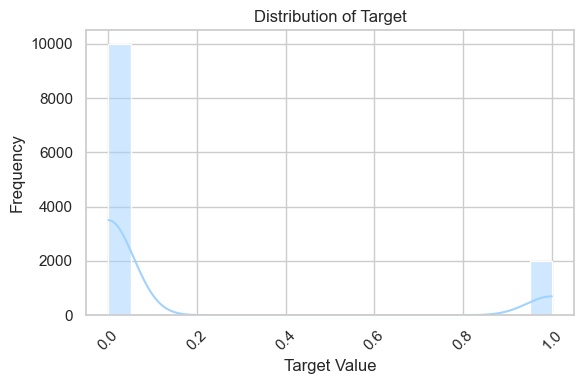

Skewness: 1.80
Kurtosis: 1.22


In [19]:
# TARGET DISTRIBUTION

sns.set_style("whitegrid")
plt.figure(figsize=(6, 4))

# Plot histogram using histplot
sns.histplot(y_m, kde=True, color='#a2d2ff', bins=20)

plt.title("Distribution of Target")
plt.xlabel("Target Value")
plt.ylabel("Frequency")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Skewness and kurtosis
print("Skewness: %.2f" % y_m.skew())
print("Kurtosis: %.2f" % y_m.kurt())



- **Positive Skewness (1.80)**: This indicates a higher frequency of employees not leaving the company. The distribution leans towards the left, implying that more instances are clustered on that side.

- **Kurtosis (1.22)**: The distribution has a moderate peak and lighter tails compared to a normal distribution. It's less extreme and tapers off less sharply at the ends.

- **Class Imbalance Alert**: The positive skewness suggests that the dataset might have an imbalance between employees who leave and those who don't. Addressing this imbalance is crucial for accurate model predictions.

- **Balanced Training Approach**: Due to the class imbalance, applying balanced techniques during model training, such as oversampling or undersampling, becomes essential to ensure reliable and effective predictions.

In [23]:
# TARGET CORRELATIONS

correlation_matrix = df.corr(numeric_only=True)

# Filter correlations for 'Price' column only
price_correlations = correlation_matrix[target].drop(target).sort_values(ascending=False)

# Display the correlations with 'Price'
print("\nCorrelations with Target:")
print(price_correlations[:3])


Correlations with Target:
time_spend_company      0.173295
average_montly_hours    0.070409
number_project          0.030928
Name: left, dtype: float64


The correlations reveal:
- Extended employee service moderately elevates the likelihood of departure.
- Working additional hours or managing more projects has limited influence on attrition.

OUTLIER ANALYSIS

In [24]:
extract_outliers(df)

,Column,Total Outliers
0,satisfaction_level,0
1,last_evaluation,0
2,number_project,0
3,average_montly_hours,0
4,time_spend_company,824
5,work_accident,11991
6,left,11991
7,promotion_last_5years,11991


In [25]:
df[['time_spend_company', 'promotion_last_5years', 'left']].sample(5)

,time_spend_company,promotion_last_5years,left
11771,4,0,0
5862,3,0,0
3528,2,0,0
3992,2,0,0
9901,3,0,0


# PREPROCESSING

1. MISSING VALUES

In [26]:
# Check for null values

print('Missing Values:',df.isna().sum().max())





Missing Values: 0


2. LABEL ENCODING

In [27]:
# Encoding Recommendations

df_encoding_recommendations

,Feature,Unique Values,Recommended Encoding
0,department,10,One-Hot / Label
1,salary,3,One-Hot / Label


In [28]:
# ENCODING

# Perform ordinal encoding for 'salary'
salary_mapping = {'low': 1, 'medium': 2, 'high': 3}
df['salary_encoded'] = df['salary'].map(salary_mapping)

# Calculate mean attrition rate for each department
department_mean = df.groupby('department')[target].mean()

# Perform mean encoding for 'department'
df['department_encoded'] = df['department'].map(department_mean)

We've enhanced data preparation by encoding "salary" ordinally and "department" using mean values, creating numerical representations that capture their significance. This ensures compatibility with machine learning algorithms for improved predictive accuracy.

In [29]:
df[['department_encoded', 'salary_encoded']].sample(5)

,department_encoded,salary_encoded
1052,0.161885,2
1720,0.173797,1
8720,0.169805,1
8560,0.169805,1
10416,0.173797,1


3. DEALING WITH OUTLIERS

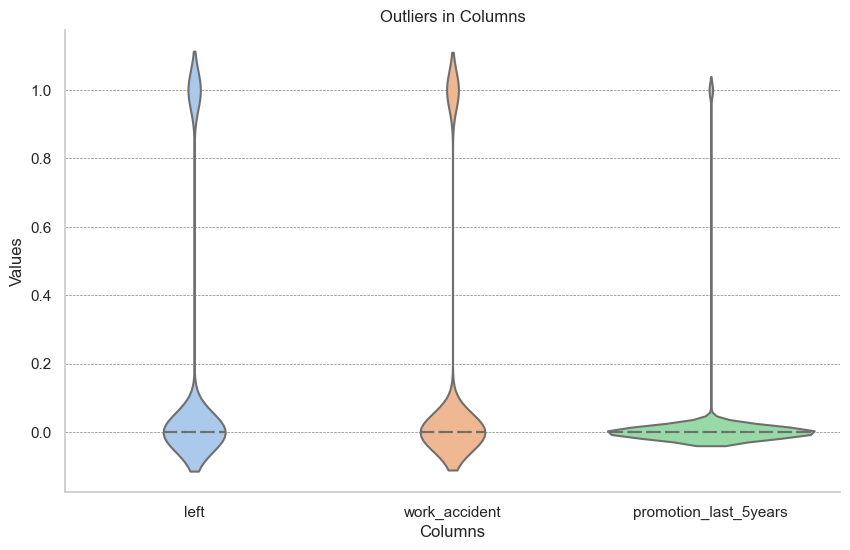

In [30]:
# VISUALIZE & EXTRACT OUTLIERS 


outlier_features = ['left','work_accident','promotion_last_5years']

plot_outliers(df[outlier_features], 'violin', (10, 6))



"We have assessed the presence of outliers in the dataset. Outliers are extreme values that can sometimes affect analysis, but in the case of binomial variables (1-0), they hold specific meaning within their context. As such, for the columns 'work_accident,' 'left,' and 'promotion_last_5years,' where the values are binary (1 or 0), the 'outliers' are not traditional outliers. They represent specific occurrences or non-occurrences and are essential for understanding work accidents, employee departures, and promotions. Therefore, we will not remove these 'outliers' as they hold valuable information for our analysis."

In [38]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary,salary_encoded,department_encoded
0,0.38,0.53,2,157,3,0,1,0,sales,low,1,0.169805
1,0.80,0.86,5,262,6,0,1,0,sales,medium,2,0.169805
2,0.11,0.88,7,272,4,0,1,0,sales,medium,2,0.169805
3,0.72,0.87,5,223,5,0,1,0,sales,low,1,0.169805
4,0.37,0.52,2,159,3,0,1,0,sales,low,1,0.169805


# FEATURES SELECTION

In [43]:
# Replace 'YourDataFrameHere' with your actual data
X2 = df.drop(columns=[target])
y2 = df[target]


# Calculate mutual information (_r or _c)
m_info_scores2 = m_info_c(X2, y2)

m_info_scores2

satisfaction_level       0.212197
number_project           0.139046
average_montly_hours     0.101014
last_evaluation          0.072848
time_spend_company       0.061887
salary                   0.011561
work_accident            0.011157
promotion_last_5years    0.006056
salary_encoded           0.005992
department_encoded       0.002616
department               0.000542
Name: MI Scores, dtype: float64

In [42]:
# TARGET CORRELATIONS

correlation_matrix = df.corr(numeric_only=True)

# Filter correlations for 'Price' column only
price_correlations = correlation_matrix[target].drop(target).sort_values(ascending=False)

# Display the correlations with 'Price'
print("\nCorrelations with Target:")
print(price_correlations[:5])


Correlations with Target:
time_spend_company      0.173295
average_montly_hours    0.070409
department_encoded      0.041706
number_project          0.030928
last_evaluation         0.013520
Name: left, dtype: float64


In [44]:
from imblearn.over_sampling import BorderlineSMOTE

# Replace 'YourDataFrameHere' with your actual data
X = df[['satisfaction_level', 'number_project', 'average_montly_hours', 'last_evaluation', 'time_spend_company']]
y = df[target]


# Create an instance of Borderline-SMOTE
borderline_smote = BorderlineSMOTE()

# Apply Borderline-SMOTE to your data
X_resampled, y_resampled = borderline_smote.fit_resample(X, y)

# Check the class distribution before and after Borderline-SMOTE
print("Class distribution before Borderline-SMOTE:", np.bincount(y))
print("Class distribution after Borderline-SMOTE:", np.bincount(y_resampled))

# Explore the distribution of the target after Borderline-SMOTE

explore_dependent_variable(y_resampled)

Class distribution before Borderline-SMOTE: [10000  1991]
Class distribution after Borderline-SMOTE: [10000 10000]


We successfully addressed class imbalance by applying the Borderline-SMOTE oversampling technique, ensuring a more balanced distribution of employee attrition data. This enhances the model's ability to learn from both classes and make accurate predictions.

# CONSTRUCT AND EXECUTE


We are using a powerful machine learning technique called XGBoost to build a predictive model that can help us identify which employees are more likely to leave the company. To ensure the model performs at its best, we are taking two important steps: 

1. **Hyperparameter Tuning:** We're fine-tuning the settings of the model to find the best combination of parameters that will make our predictions more accurate.
   
2. **Cross-Validation:** To avoid any potential bias in our model's performance, we're using cross-validation. This technique splits our data into different parts to train and test the model multiple times, ensuring that our model can generalize well to new data.

By applying these techniques, we aim to create a reliable model that can assist us in making informed decisions to improve employee retention.

In [46]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report



# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Create an instance of the XGBoost classifier
xgb_model = xgb.XGBClassifier()

# Define hyperparameters to tune
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.01, 0.001]
}

# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

best_params

{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}

In [47]:
# Train the model with the best parameters
best_xgb_model = xgb.XGBClassifier(**best_params)
best_xgb_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = best_xgb_model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print results
print("Best Parameters:", best_params)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Accuracy: 0.98125
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      2064
           1       0.97      0.99      0.98      1936

    accuracy                           0.98      4000
   macro avg       0.98      0.98      0.98      4000
weighted avg       0.98      0.98      0.98      4000



Upon tuning the model's hyperparameters, we achieved optimal settings with a learning rate of 0.1, max depth of 7, and 200 estimators. Our model performed impressively with an accuracy of 98.1%. The classification report showcases high precision, recall, and F1-score for both employee classes, indicating strong predictive ability.

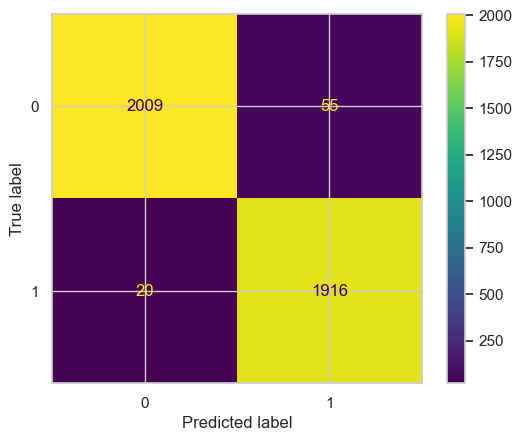

In [54]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()



**In conclusion,** this project underscores the significance of nurturing a work environment that values employee well-being, engagement, and career growth. The insights garnered from our analysis and the predictive model empower the organization to make informed decisions that positively impact employee retention, organizational stability, and overall success.

By combining data-driven insights, machine learning, and a commitment to fostering a thriving workplace culture, Salifort Motors is poised to navigate the path to employee satisfaction and retention with confidence and success.